In [1]:
import pandas as pd
import math
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

# Import CSV

In [2]:
dataframe = pd.read_csv('data.csv')
dataframe

,km,price
0,240000,3650
1,139800,3800
2,150500,4400
3,185530,4450
4,176000,5250
5,114800,5350
6,166800,5800
7,89000,5990
8,144500,5999
9,84000,6200


# Data normalization

In [3]:
km = dataframe['km']
km_avg = np.average(km)
km_std_dev = math.sqrt( np.sum( (km - km_avg)**2 ) / km.size)

def normalize_km(km):
    return (km - km_avg) / km_std_dev

dataframe = dataframe.assign(km_nrm= lambda x: normalize_km(x.km))

In [4]:
price = dataframe['price']
price_avg = np.average(price)
price_std_dev = math.sqrt( np.sum( (price - price_avg)**2 ) / price.size)

def normalize_price(price) :
    return (price - price_avg) / price_std_dev

def denormalize_price(normalized_price) :
    return (normalized_price * price_std_dev) + price_avg

dataframe = dataframe.assign(price_nrm= lambda x: normalize_price(x.price))
dataframe

,km,price,km_nrm,price_nrm
0,240000,3650,2.694332,-2.075933
1,139800,3800,0.751161,-1.959822
2,150500,4400,0.958665,-1.495379
3,185530,4450,1.637999,-1.456675
4,176000,5250,1.453185,-0.837417
5,114800,5350,0.266338,-0.760010
6,166800,5800,1.274770,-0.411677
7,89000,5990,-0.234000,-0.264604
8,144500,5999,0.842308,-0.257637
9,84000,6200,-0.330965,-0.102049


# Model

In [13]:
@dataclass
class Model:
    minibatchSize = 7
    lr = 1e-4
    theta : np.array = np.zeros(2)
      
model = Model()
print(model.theta)

[0. 0.]


# Predict

In [6]:
def predict_nrm(model : Model, km_nrm) :
    return (model.theta[0]  + model.theta[1] * km_nrm)

In [7]:
def predict(model : Model, km) :
    return denormalize_price(predict_nrm(model, normalize_km(km)))

# Plot

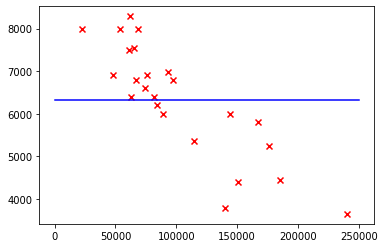

In [8]:
class Plot:
    def __init__(self, model : Model, data : pd.DataFrame):
        plt.ion()

        self.fig = plt.figure()
        self.sub = self.fig.add_subplot(1,1,1)
        self.model = model
        self.data = data
        
        self.sub.scatter(data["km"], data["price"], color = 'r', marker='x')
        x = np.array([0, 250000])
        y = predict(model, x)
        self.pred, = self.sub.plot(x,y, 'b-')
        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
        
    def draw(self):
        x = np.array([0, 250000])
        y = predict(model, x)
        self.pred.set_ydata(y)
        
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    
    
plot = Plot(model,dataframe)
plot.draw()

# Train

In [14]:
def loss(y, y_hat):
    m = len(y)
    if m != len(y_hat) :
        raise Exception("y and y_hat have different sizes")
        
    return np.sum((y - y_hat)**2) / (2*m)

In [16]:
def training_step(model : Model, data : pd.DataFrame):
    sample = data.sample(model.minibatchSize)
    
    x = sample['km_nrm'].to_numpy()
    y = sample['price_nrm'].to_numpy()
    y_hat = predict_nrm(model, x)
    
    x_ = np.array([ np.ones(model.minibatchSize),x])
    model.theta -= (model.lr / model.minibatchSize) * ((y_hat - y) @ x_.transpose())
       
    return (loss(y, y_hat))

l= training_step(model,dataframe)
print("loss: " + str(l))

loss: 0.8183946886965721


loss: 0.36707495416726904
loss: 0.21776436946750846
loss: 0.16582390066441352
loss: 0.14633605827149412
loss: 0.13826014174832932
loss: 0.1356751340161807
loss: 0.1346583214590005
loss: 0.13399824519736175
loss: 0.13413534665713672
loss: 0.13365898597240114


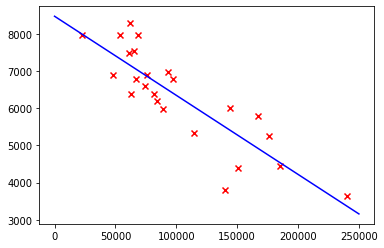

In [17]:
def train(steps : int, model : Model, data : pd.DataFrame, print_every : int = 100):
    l=0
    for i in range(steps):
        l += training_step(model, data)
        if (i+1) % print_every == 0 :
            print("loss: " + str(l/print_every))
            l=0
        
    Plot(model,dataframe).draw()

    
train(50000, model, dataframe, 5000)

# Play around

In [12]:
predict(model, 0)

8486.162616882233

# Cheat

Now that I've shown that I can implement linear regression by myself, I would be interested in seeing how it is done in the real world using any library available out there.

In [32]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()
m = len(dataframe['km'])
X = np.array([ np.ones(m), dataframe['km'] ])
y = dataframe['price'].to_numpy()
print(X,y)
model = model.fit(X,y)

model.score( dataframe['km'], dataframe['price'] )

[[1.0000e+00 2.4000e+05]
 [1.0000e+00 1.3980e+05]
 [1.0000e+00 1.5050e+05]
 [1.0000e+00 1.8553e+05]
 [1.0000e+00 1.7600e+05]
 [1.0000e+00 1.1480e+05]
 [1.0000e+00 1.6680e+05]
 [1.0000e+00 8.9000e+04]
 [1.0000e+00 1.4450e+05]
 [1.0000e+00 8.4000e+04]
 [1.0000e+00 8.2029e+04]
 [1.0000e+00 6.3060e+04]
 [1.0000e+00 7.4000e+04]
 [1.0000e+00 9.7500e+04]
 [1.0000e+00 6.7000e+04]
 [1.0000e+00 7.6025e+04]
 [1.0000e+00 4.8235e+04]
 [1.0000e+00 9.3000e+04]
 [1.0000e+00 6.0949e+04]
 [1.0000e+00 6.5674e+04]
 [1.0000e+00 5.4000e+04]
 [1.0000e+00 6.8500e+04]
 [1.0000e+00 2.2899e+04]
 [1.0000e+00 6.1789e+04]] [3650 3800 4400 4450 5250 5350 5800 5990 5999 6200 6390 6390 6600 6800
 6800 6900 6900 6990 7490 7555 7990 7990 7990 8290]


ValueError: Expected 2D array, got 1D array instead:
array=[240000 139800 150500 185530 176000 114800 166800  89000 144500  84000
  82029  63060  74000  97500  67000  76025  48235  93000  60949  65674
  54000  68500  22899  61789].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Never said I was good at cheating...